## Домашнее задание №4

В качестве домашнего задания предлагаются следующие задачи:

1) Реализовать метод аугментации текстовых данных на основе дистрибутивных векторных представлений, который можно применить в перечисленных ниже задачах (на выбор) и проанализировать итоговое качество с/без аугментации.

2) Решить задачу регрессии с использованием текстовых признаков на англоязычном датасете [Medium Stories](https://www.kaggle.com/harrisonjansma/medium-stories).

3) Решить задачу детекции парафразов.

4) Использовать методы для нахождения оптимальных гиперпараметров модели.

5) Использовать кросс-валидацию и/или методы семплирования данных.

Это домашнее задание является "конструктором": вы можете выполнить интересующие вас блоки или получить больше 10 баллов.

Если качество моделей не повысилось, но попытка реализована верно, вы все равно получаете баллы (например, при конструировании собственных текстовых признаков). 

Дедлайн: **18 октября 23:59**


### Блок 1: Аугментация с заменой слов на основе ```word2vec``` (2 балла)

* Можно использовать библиотеку ```gensim``` и модели [rusvectores](https://rusvectores.org/ru/models/)



In [2]:
# !wget -c http://vectors.nlpl.eu/repository/20/180.zip
# !unzip 180.zip

In [1]:
import os
import gensim

model_path = r'C:\Users\User\Documents\embeddings\ruscorpora_upos_cbow_300_20_2019'

model = gensim.models.KeyedVectors.load_word2vec_format(os.path.join(model_path, "model.bin"), binary=True)
model.init_sims(replace=True)

In [2]:
import spacy

nlp = spacy.load('ru2')

In [3]:
def pos_tag(sent):
    doc = nlp(sent)
    return [(w.text, w.lemma_, w.pos_, w.tag_) for w in doc]

In [72]:
set([x.split('_')[1] for x in list(model.vocab.keys())])

{'ADJ', 'ADV', 'INTJ', 'NOUN', 'NUM', 'PROPN', 'SYM', 'VERB', 'X'}

Напишите функцию, которая заменяет слова во входном предложении их ближайшими семантическими ассоциатами (1 балл).

In [174]:
def augment_word2vec(sentence, model=model, log=False):
    tagged = pos_tag(sentence)
    if log:
        print(tagged)
    result = ''
    for token, lemma, tag, _ in tagged:
    
        if tag == 'PUNCT':
            result += token
        elif tag in ['X', 'NUM', 'SYM',
                     'ADP', 'AUX', 'CCONJ', 'SCONJ',
                     'DET', 'PART', 'PRON']:
            result += ' ' + token
        else:
            lemma = lemma.replace('ё', 'е')
            raw_token = f'{lemma}_{tag}'
            if raw_token in model:
                top_sim = model.most_similar(positive=[raw_token], topn=5)
                for sim in top_sim:
                    new_token = sim[0].split('_')[0]
                    if new_token != lemma:
                            break
                
                result += ' ' + new_token
                if log:
                    print(f'{token} -> {new_token}')
            else:
                result += ' ' + token
    return result.strip()

In [175]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sent = "мама помыла окно"

# пример работы наивной функции
augment_word2vec(sent, model=model, log=True)

[('мама', 'мама', 'NOUN', 'NOUN__Animacy=Anim|Case=Nom|Gender=Fem|Number=Sing'), ('помыла', 'помыла', 'VERB', 'VERB__Aspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act'), ('окно', 'окно', 'NOUN', 'NOUN__Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing')]
мама -> бабушка
окно -> окошко


'бабушка помыла окошко'

In [6]:
augment_word2vec('моя учительница по музыке любит кушать бутерброды с юными учениками', model=model, log=True)

[('моя', 'мой', 'DET', 'DET__Case=Nom|Gender=Fem|Number=Sing'), ('учительница', 'учительница', 'NOUN', 'NOUN__Animacy=Anim|Case=Nom|Gender=Fem|Number=Sing'), ('по', 'по', 'ADP', 'ADP___'), ('музыке', 'музыка', 'NOUN', 'NOUN__Animacy=Inan|Case=Dat|Gender=Fem|Number=Sing'), ('любит', 'любить', 'VERB', 'VERB__Aspect=Imp|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act'), ('кушать', 'кушать', 'VERB', 'VERB__Aspect=Imp|VerbForm=Inf|Voice=Act'), ('бутерброды', 'бутерброд', 'NOUN', 'NOUN__Animacy=Inan|Case=Acc|Gender=Masc|Number=Plur'), ('с', 'с', 'ADP', 'ADP___'), ('юными', 'юный', 'ADJ', 'ADJ__Case=Ins|Degree=Pos|Number=Plur'), ('учениками', 'ученик', 'NOUN', 'NOUN__Animacy=Anim|Case=Ins|Gender=Masc|Number=Plur')]
учительница -> училка
музыке -> джаз
любит -> нравиться
кушать -> откушать
бутерброды -> котлета
юными -> молоденький
учениками -> педагог


'моя училка по джаз нравиться откушать котлета с молоденький педагог'

In [7]:
gimn = '''Россия — священная наша держава,
Россия — любимая наша страна.
Могучая воля, великая слава —
Твоё достоянье на все времена!

Славься, Отечество наше свободное,
Братских народов союз вековой,
Предками данная мудрость народная!
Славься, страна! Мы гордимся тобой!'''

for stroka in gimn.split('\n'):
    print(augment_word2vec(stroka, model=model))

германия — освящять наша княжество,
германия — обожать наша республика.
исполинский своеволие, равноапостольный хвала —
Твоё сокровищница на все момент!

Славься, доблестный наше независимый,
-илимский государство организация тысячелетний,
пращура данная разум национальный!
Славься, республика! Мы восхищаться тобой!


Измените функцию так, чтобы заменялись слова, относящиеся к заданному набору пос-тегов (например, ADJ, NOUN), и сохранялась грамматика (1 балл). 

In [8]:
import re

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [199]:
def augment_word2vec_pos(sentence, model, log=False):
    
    allowed_pos = ['NOUN', 'ADJ']
    
    tagged = pos_tag(sentence)
    if log:
        print(tagged)
    result = ''
    for token, lemma, tag, gram in tagged:
    
        if tag == 'PUNCT':
            result += token
        else:
            if tag in allowed_pos:
                lemma = lemma.replace('ё', 'е')
                raw_token = f'{lemma}_{tag}'
                if raw_token in model:
                    top_sim = model.most_similar(positive=[raw_token], topn=10)
                    for sim in top_sim:
                        new_token = sim[0].split('_')[0]
                        if new_token != lemma:
                            break
                    try:
                        number = re.search('Number=(.*?)$', gram).group(1).lower()
                        new_token = morph.parse(new_token)[0].inflect({number}).word
                    except:
                        pass
                    
                    if log:
                        print(f'{token} -> {new_token}')
                    token = new_token
    
            result += ' ' + token
    return result.strip()

In [200]:
augment_word2vec_pos('маленькие дети любят думать о быстрых поездах', model=model, log=True)

[('маленькие', 'маленький', 'ADJ', 'ADJ__Case=Nom|Degree=Pos|Number=Plur'), ('дети', 'ребёнок', 'NOUN', 'NOUN__Animacy=Anim|Case=Nom|Gender=Masc|Number=Plur'), ('любят', 'любить', 'VERB', 'VERB__Aspect=Imp|Mood=Ind|Number=Plur|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act'), ('думать', 'думать', 'VERB', 'VERB__Aspect=Imp|VerbForm=Inf|Voice=Act'), ('о', 'о', 'ADP', 'ADP___'), ('быстрых', 'быстрый', 'ADJ', 'ADJ__Case=Loc|Degree=Pos|Number=Plur'), ('поездах', 'поезд', 'NOUN', 'NOUN__Animacy=Inan|Case=Loc|Gender=Masc|Number=Plur')]
маленькие -> крошечные
дети -> детишки
быстрых -> стремительные
поездах -> вагоны


'крошечные детишки любят думать о стремительные вагоны'

In [201]:
augment_word2vec('маленькие дети любят думать о быстрых поездах', model=model, log=True)

[('маленькие', 'маленький', 'ADJ', 'ADJ__Case=Nom|Degree=Pos|Number=Plur'), ('дети', 'ребёнок', 'NOUN', 'NOUN__Animacy=Anim|Case=Nom|Gender=Masc|Number=Plur'), ('любят', 'любить', 'VERB', 'VERB__Aspect=Imp|Mood=Ind|Number=Plur|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act'), ('думать', 'думать', 'VERB', 'VERB__Aspect=Imp|VerbForm=Inf|Voice=Act'), ('о', 'о', 'ADP', 'ADP___'), ('быстрых', 'быстрый', 'ADJ', 'ADJ__Case=Loc|Degree=Pos|Number=Plur'), ('поездах', 'поезд', 'NOUN', 'NOUN__Animacy=Inan|Case=Loc|Gender=Masc|Number=Plur')]
маленькие -> крошечный
дети -> детишки
любят -> обожать
думать -> подумать
быстрых -> стремительный
поездах -> вагон


'крошечный детишки обожать подумать о стремительный вагон'

### Блок 3: Paraphrase Detection (до 8 баллов)


* [Статья по русскоязычному корпусу парафразов](https://www.aclweb.org/anthology/2020.ngt-1.6/)
* [Еще статья](http://www.dialog-21.ru/media/3928/loukachevitchnvetal.pdf)
* [Сайт корпуса](http://paraphraser.ru/)

Отформатированные данные можно скачать [здесь](https://yadi.sk/d/OIgbnRA6OVJ4VQ)


1. [X]  Эксплоративный анализ данных (1 балл)
2. [X]  Поиск гиперпараметров, минимизация переобучения (2 балла)
3. [X]  Аугментация данных (1 балл)
4. [X]  Сравнение качества моделей, выбор наилучшей (1 балл)
5. [X]  Конструирование текстовых признаков (2 балла)
6. [X]  Анализ ошибок (1 балл)

__NB: уже готовые датафреймы можно загрузить из файлов `para.tsv` и `augmented_para.tsv` и пропустить все шаги до собственно [этапа обучения моделей](#Данные)__

In [12]:
import pandas as pd

from tqdm.auto import tqdm
tqdm.pandas()

In [13]:
para = pd.read_csv("paraphrases.tsv", sep="\t")
para.head()

,text_1,text_2,class
0,Совет юстиции Бразилии легализовал однополые б...,Совет юстиции Бразилии разрешил однополые браки.,1
1,"""Магнит"" поручится перед ""Абсолют Банком"" за к...",Выпуск сигарет в России упал из-за антитабачно...,-1
2,ЕС призвал США не бомбить Сирию до публикации ...,Евросоюз призвал США дождаться доклада ООН по ...,-1
3,Депо Московского метрополитена впервые перейде...,Частной компании впервые отдадут депо в москов...,1
4,Два человека погибли в столкновениях между кур...,Один человек погиб при столкновении судов у бе...,-1


In [14]:
para['class'].value_counts()

-1    5164
 1    3376
Name: class, dtype: int64

In [15]:
def recode_class(i):
    if i == -1:
        i = 0
    return i

In [16]:
para['class'] = para['class'].apply(recode_class)
para.head()

,text_1,text_2,class
0,Совет юстиции Бразилии легализовал однополые б...,Совет юстиции Бразилии разрешил однополые браки.,1
1,"""Магнит"" поручится перед ""Абсолют Банком"" за к...",Выпуск сигарет в России упал из-за антитабачно...,0
2,ЕС призвал США не бомбить Сирию до публикации ...,Евросоюз призвал США дождаться доклада ООН по ...,0
3,Депо Московского метрополитена впервые перейде...,Частной компании впервые отдадут депо в москов...,1
4,Два человека погибли в столкновениях между кур...,Один человек погиб при столкновении судов у бе...,0


In [17]:
para.drop_duplicates(inplace=True)
para.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4257 entries, 0 to 8495
Data columns (total 3 columns):
text_1    4257 non-null object
text_2    4257 non-null object
class     4257 non-null int64
dtypes: int64(1), object(2)
memory usage: 133.0+ KB


## Текстовые признаки

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Длины

In [18]:
import re
from razdel import tokenize
from nltk.corpus import stopwords
stops = stopwords.words("russian")

from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

def tokenizer(text_data):
    tokens = [_.text for _ in list(tokenize(str(text_data).lower()))] #if not re.search('[^а-яА-ЯёЁa-zA-z]', _.text)]
    return " ".join(tokens)

def get_words(tokens):
    words = [token for token in tokens.split() if not re.search('[^а-яА-ЯёЁa-zA-z]', token)]
    return " ".join(words)

def count_words(words):
    return len(words.split())

def av_word_length(words):
    l = [len(word) for word in words.split()]
    return sum(l)/len(l)

def lemmatizer(tokens):
    lem_text = []
    for word in tokens.split():
        lem = morph.parse(word)[0].normal_form
        if lem not in stops:
            lem_text.append(lem)
    return ' '.join(lem_text)

In [19]:
for i in [1, 2]:
    para[f'tokens_{i}'] = para[f'text_{i}'].progress_apply(tokenizer)
    para[f'words_{i}'] = para[f'tokens_{i}'].progress_apply(get_words)
    para[f'n_words_{i}'] = para[f'words_{i}'].progress_apply(count_words)
    para[f'av_words_length_{i}'] = para[f'words_{i}'].progress_apply(av_word_length)

In [25]:
para['n_words_diff'] = para['n_words_1'] - para['n_words_2']

### Частеречные различия

In [229]:
tag_list = ['ADJF', 'ADJS', 'ADVB', 'COMP', 'CONJ', 'GRND', 'INFN', 'INTJ', 'NOUN',
            'NPRO', 'NUMR', 'None', 'PRCL', 'PRED', 'PREP', 'PRTF', 'PRTS', 'VERB']

def count_POS(words):
    POS_dict = {'ADJF': 0,
                'ADJS': 0,
                'ADVB': 0,
                'COMP': 0,
                'CONJ': 0,
                'GRND': 0,
                'INFN': 0,
                'INTJ': 0,
                'NOUN': 0,
                'NPRO': 0,
                'NUMR': 0,
                'None': 0,
                'PRCL': 0,
                'PRED': 0,
                'PREP': 0,
                'PRTF': 0,
                'PRTS': 0,
                'VERB': 0}
    
    for word in words.split():
        p = morph.parse(word)[0]
        tag = p.tag.POS
        if tag is None:
            tag = 'None'
        POS_dict[tag] += 1
    return list(POS_dict.values())

In [230]:
for i in [1, 2]:
    para[f'pos_vector_{i}'] = para[f'words_{i}'].progress_apply(count_POS)

In [231]:
def substract(a, b):
    return [a_i - b_i for a_i, b_i in zip(a, b)]

In [232]:
para['pos_diff'] = [substract(p1, p2) for p1, p2 in zip(para.pos_vector_1, para.pos_vector_2)]
para[ [tag for tag in tag_list] ] = para['pos_diff'].tolist()

In [233]:
para[ [tag for tag in tag_list] ].describe()

,ADJF,ADJS,ADVB,COMP,CONJ,GRND,INFN,INTJ,NOUN,NPRO,NUMR,None,PRCL,PRED,PREP,PRTF,PRTS,VERB
count,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000
mean,0.023021,-0.009161,0.006108,-0.001409,-0.054264,0.002819,0.017383,0.004933,0.381959,-0.003054,-0.007047,0.023256,-0.014799,0.001409,0.155743,0.009631,0.041579,-0.052619
std,0.777344,0.267544,0.363334,0.116730,0.550646,0.061249,0.357753,0.087917,1.426697,0.202754,0.240315,0.371284,0.360160,0.124521,0.976190,0.277867,0.343317,0.521667
min,-4.000000,-2.000000,-3.000000,-2.000000,-3.000000,-1.000000,-2.000000,-1.000000,-7.000000,-3.000000,-1.000000,-5.000000,-3.000000,-2.000000,-3.000000,-2.000000,-1.000000,-3.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,3.000000,1.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,6.000000,2.000000,1.000000,4.000000,3.000000,1.000000,5.000000,1.000000,2.000000,2.000000


### Подсчет кол-ва повторяющихся лемм

In [31]:
def lemmatizer(words):
    lem_text = []
    for word in words.split():
        lem = morph.parse(word)[0].normal_form
#         if lem not in stops:
        lem_text.append(lem)
    return ' '.join(lem_text)

def similar_words(lemm_a, lemm_b):
    return list(set(lemm_a.split()) & set(lemm_b.split()))

In [32]:
for i in [1, 2]:
    para[f'lemm_{i}'] = para[f'words_{i}'].progress_apply(lemmatizer)

In [33]:
para['similar_words'] = para.apply(lambda x: similar_words(x['lemm_1'], x['lemm_2']), axis=1)
para['n_similar_words'] = para['similar_words'].apply(len)

## Анализ признаков

In [59]:
para.groupby(by='class').mean()

,n_words_1,av_words_length_1,n_words_2,av_words_length_2,n_words_diff,ADJF,ADJS,ADVB,COMP,CONJ,...,NPRO,NUMR,None,PRCL,PRED,PREP,PRTF,PRTS,VERB,n_similar_words
class,,,,,,,,,,,,,,,,,,,,,
0,8.163622,6.168893,7.546055,6.208051,0.617567,0.028372,-0.020599,-0.003887,-0.004275,-0.102993,...,-0.005441,0.002332,0.02021,-0.036145,-0.000777,0.235134,0.009328,0.038088,-0.057520,2.571318
1,7.577791,6.340904,7.192993,6.447741,0.384798,0.014846,0.008314,0.021378,0.002969,0.020190,...,0.000594,-0.021378,0.02791,0.017815,0.004751,0.034442,0.010095,0.046912,-0.045131,5.187055


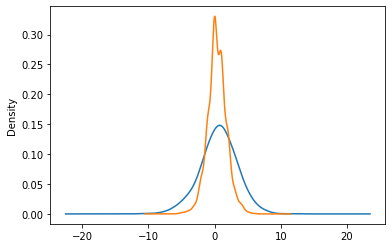

In [69]:
bw_method=0.3
para[para['class'] == 0]['n_words_diff'].plot.kde(bw_method) #blue
para[para['class'] == 1]['n_words_diff'].plot.kde(bw_method) #orange

In [81]:
features = ['class',
            'n_words_1', 'av_words_length_1',
            'n_words_2', 'av_words_length_2',
            'n_words_diff', 
            'ADJF','ADJS', 'ADVB', 'COMP', 'CONJ', 'GRND', 
            'INFN', 'INTJ', 'NOUN','NPRO', 'NUMR', 'None', 
            'PRCL', 'PRED', 'PREP', 'PRTF', 'PRTS', 'VERB', 
            'n_similar_words']

In [82]:
data = para[features]

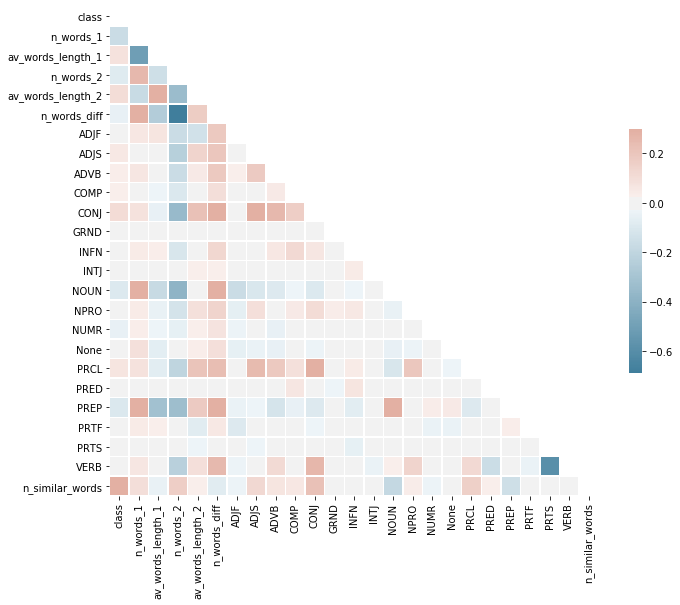

In [83]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

При перифразе кол-во одинаковых (неизмененных слов) больше:

In [84]:
para[['class', 'n_similar_words']].corr()

,class,n_similar_words
class,1.00000,0.58123
n_similar_words,0.58123,1.00000


Один из сновных способов перифраза - изменение залога: глагол -> краткое причастие

In [85]:
para[['VERB', 'PRTS']].corr()

,VERB,PRTS
VERB,1.000000,-0.592579
PRTS,-0.592579,1.000000


In [86]:
para.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4257 entries, 0 to 8495
Data columns (total 38 columns):
text_1               4257 non-null object
text_2               4257 non-null object
class                4257 non-null int64
tokens_1             4257 non-null object
words_1              4257 non-null object
n_words_1            4257 non-null int64
av_words_length_1    4257 non-null float64
tokens_2             4257 non-null object
words_2              4257 non-null object
n_words_2            4257 non-null int64
av_words_length_2    4257 non-null float64
n_words_diff         4257 non-null int64
pos_vector_1         4257 non-null object
pos_vector_2         4257 non-null object
pos_diff             4257 non-null object
ADJF                 4257 non-null int64
ADJS                 4257 non-null int64
ADVB                 4257 non-null int64
COMP                 4257 non-null int64
CONJ                 4257 non-null int64
GRND                 4257 non-null int64
INFN               

## Векторные признаки

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [88]:
para['combine'] = para['lemm_1'] + ' ' +  para['lemm_2']
para.head()

,text_1,text_2,class,tokens_1,words_1,n_words_1,av_words_length_1,tokens_2,words_2,n_words_2,...,PRED,PREP,PRTF,PRTS,VERB,lemm_1,lemm_2,similar_words,n_similar_words,combine
0,Совет юстиции Бразилии легализовал однополые б...,Совет юстиции Бразилии разрешил однополые браки.,1,совет юстиции бразилии легализовал однополые б...,совет юстиции бразилии легализовал однополые б...,6,7.500000,совет юстиции бразилии разрешил однополые браки .,совет юстиции бразилии разрешил однополые браки,6,...,0,0,0,0,0,совет юстиция бразилия легализовать однополый ...,совет юстиция бразилия разрешить однополый брак,"[бразилия, совет, брак, юстиция, однополый]",5,совет юстиция бразилия легализовать однополый ...
1,"""Магнит"" поручится перед ""Абсолют Банком"" за к...",Выпуск сигарет в России упал из-за антитабачно...,0,""" магнит "" поручится перед "" абсолют банком "" ...",магнит поручится перед абсолют банком за креди...,10,5.000000,выпуск сигарет в россии упал из-за антитабачно...,выпуск сигарет в россии упал антитабачного закона,7,...,0,2,0,0,0,магнит поручиться перед абсолют банк за кредит...,выпуск сигарета в россия упасть антитабачный з...,[],0,магнит поручиться перед абсолют банк за кредит...
2,ЕС призвал США не бомбить Сирию до публикации ...,Евросоюз призвал США дождаться доклада ООН по ...,0,ес призвал сша не бомбить сирию до публикации ...,ес призвал сша не бомбить сирию до публикации ...,10,4.800000,евросоюз призвал сша дождаться доклада оон по ...,евросоюз призвал сша дождаться доклада оон по ...,8,...,0,0,0,0,0,ес призвать сша не бомбить сирия до публикация...,евросоюз призвать сша дождаться доклад оон по ...,"[сирия, доклад, сша, оон, призвать]",5,ес призвать сша не бомбить сирия до публикация...
3,Депо Московского метрополитена впервые перейде...,Частной компании впервые отдадут депо в москов...,1,депо московского метрополитена впервые перейде...,депо московского метрополитена впервые перейде...,8,6.875000,частной компании впервые отдадут депо в москов...,частной компании впервые отдадут депо в москов...,8,...,0,0,0,0,0,депо московский метрополитен впервые перейти в...,частный компания впервые отдать депо в московс...,"[в, впервые, московский, депо]",4,депо московский метрополитен впервые перейти в...
4,Два человека погибли в столкновениях между кур...,Один человек погиб при столкновении судов у бе...,0,два человека погибли в столкновениях между кур...,два человека погибли в столкновениях между кур...,9,5.666667,один человек погиб при столкновении судов у бе...,один человек погиб при столкновении судов у бе...,9,...,0,1,0,0,0,два человек погибнуть в столкновение между кур...,один человек погибнуть при столкновение судно ...,"[погибнуть, столкновение, человек]",3,два человек погибнуть в столкновение между кур...


In [89]:
vectorizer = TfidfVectorizer(analyzer=str.split)
X = vectorizer.fit_transform(para['combine'])
X.shape

(4257, 7651)

## Данные

In [90]:
features = ['class',
            'n_words_1', 'av_words_length_1',
            'n_words_2', 'av_words_length_2',
            'n_words_diff', 
            'ADJF','ADJS', 'ADVB', 'COMP', 'CONJ', 'GRND', 
            'INFN', 'INTJ', 'NOUN','NPRO', 'NUMR', 'None', 
            'PRCL', 'PRED', 'PREP', 'PRTF', 'PRTS', 'VERB', 
            'n_similar_words']

data = para[features]

y = data['class']
x = data.drop(columns=['class'])
x.head()

,n_words_1,av_words_length_1,n_words_2,av_words_length_2,n_words_diff,ADJF,ADJS,ADVB,COMP,CONJ,...,NPRO,NUMR,None,PRCL,PRED,PREP,PRTF,PRTS,VERB,n_similar_words
0,6,7.500000,6,7.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,10,5.000000,7,6.142857,3,-1,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
2,10,4.800000,8,5.500000,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,5
3,8,6.875000,8,6.125000,0,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,9,5.666667,9,5.555556,0,-1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,3


In [92]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

SEED = 42

In [96]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=SEED, stratify=y)

## Сравниваем две модели

In [106]:
clf_forest = RandomForestClassifier(n_estimators=100, random_state=SEED)
clf_forest.fit(x_train, y_train)
print(classification_report(y_test, clf_forest.predict(x_test)))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       772
           1       0.79      0.70      0.74       506

    accuracy                           0.81      1278
   macro avg       0.80      0.79      0.80      1278
weighted avg       0.81      0.81      0.81      1278



In [117]:
clf_logreg = LogisticRegression(random_state=SEED, max_iter=200, solver='liblinear')
clf_logreg.fit(x_train, y_train)
print(classification_report(y_test, clf_logreg.predict(x_test)))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       772
           1       0.78      0.74      0.76       506

    accuracy                           0.81      1278
   macro avg       0.81      0.80      0.80      1278
weighted avg       0.81      0.81      0.81      1278



### Пробуем улучшить с помощью подбора параметров

In [108]:
from sklearn.model_selection import GridSearchCV

In [127]:
params_forest = {'n_estimators': [10, 50, 100, 200], 'max_depth': [2, 5, 10, 20, 50]}
grid_forest = GridSearchCV(RandomForestClassifier(random_state=SEED), params_forest)
grid_forest.fit(x_train, y_train)

print(grid_forest.best_params_)
best_forest = grid_forest.best_estimator_
best_forest.fit(x_train, y_train)
print(classification_report(y_test, best_forest.predict(x_test)))

{'max_depth': 20, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       772
           1       0.80      0.72      0.76       506

    accuracy                           0.82      1278
   macro avg       0.81      0.80      0.81      1278
weighted avg       0.82      0.82      0.82      1278



In [128]:
params_logreg =  {'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_logreg = GridSearchCV(LogisticRegression(random_state=SEED, max_iter=200, solver='liblinear'), params_logreg)
grid_logreg.fit(x_train, y_train)

print(grid_logreg.best_params_)
best_logreg = grid_logreg.best_estimator_
best_logreg.fit(x_train, y_train)
print(classification_report(y_test, best_logreg.predict(x_test)))

{'C': 0.001, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       772
           1       0.82      0.70      0.75       506

    accuracy                           0.82      1278
   macro avg       0.82      0.80      0.81      1278
weighted avg       0.82      0.82      0.82      1278



### Сравним с качеством на векторных признаках

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

In [120]:
params_forest = {'n_estimators': [10, 50, 100, 200], 'max_depth': [2, 5, 10, 20, 50]}
g_forest = GridSearchCV(RandomForestClassifier(random_state=SEED), params_forest)
g_forest.fit(X_train, y_train)

print(g_forest.best_params_)
b_forest = g_forest.best_estimator_
b_forest.fit(X_train, y_train)
print(classification_report(y_test, b_forest.predict(X_test)))

{'max_depth': 50, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.75      0.87      0.80       772
           1       0.73      0.55      0.63       506

    accuracy                           0.74      1278
   macro avg       0.74      0.71      0.72      1278
weighted avg       0.74      0.74      0.73      1278



In [122]:
params_logreg =  {'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
g_logreg = GridSearchCV(LogisticRegression(random_state=SEED, max_iter=300, solver='liblinear'), params_logreg)
g_logreg.fit(X_train, y_train)

print(g_logreg.best_params_)
b_logreg = g_logreg.best_estimator_
b_logreg.fit(X_train, y_train)
print(classification_report(y_test, b_logreg.predict(X_test)))

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'C': 10, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.73      0.80      0.77       772
           1       0.65      0.55      0.60       506

    accuracy                           0.70      1278
   macro avg       0.69      0.68      0.68      1278
weighted avg       0.70      0.70      0.70      1278



Итого, лучше всего работает RandomForest c параметрами `max_depth=20` и `n_estimators=100` на текстовых признаках.

In [129]:
feature_importances_forest = best_forest.feature_importances_
for ind in np.argsort(-feature_importances_forest):
    print(x_train.columns[ind], '-', feature_importances_forest[ind])

n_similar_words - 0.30798789710369534
av_words_length_1 - 0.09832277655943593
av_words_length_2 - 0.0969033278215661
n_words_diff - 0.07095559018761738
n_words_2 - 0.06683212586860166
n_words_1 - 0.06337962967871767
NOUN - 0.060287381487381914
PREP - 0.04407429831494903
ADJF - 0.030823048085570987
VERB - 0.020440185942307985
PRCL - 0.019797657009530553
CONJ - 0.019583109447358228
INFN - 0.016900137137212667
ADVB - 0.01572097953771971
None - 0.013413404688499993
PRTF - 0.013310826854730609
PRTS - 0.012011059123626839
NUMR - 0.010967739450479805
ADJS - 0.008611954119559602
NPRO - 0.0031055296578852095
PRED - 0.002492543988656209
COMP - 0.002230430811106504
INTJ - 0.001422942326742646
GRND - 0.00042542479704732987


In [131]:
feature_importances_lreg = best_logreg.coef_
for ind in np.argsort(-feature_importances_lreg[0]):
    print(x_train.columns[ind], '-', feature_importances_lreg[0][ind])

n_similar_words - 0.5355923784603931
av_words_length_2 - 0.023377936800305817
ADJF - 0.00995412864286361
CONJ - 0.009679407935678092
VERB - 0.007341207594404369
PRCL - 0.006291014830495488
PRTF - 0.005739524471994745
PRED - 0.0024696921237243683
NPRO - 0.001531490754406824
COMP - 0.0010619652555258247
None - 0.0009450689587502375
INFN - 0.00015803870841889494
GRND - -1.269921352448984e-06
INTJ - -0.00031213721003688533
ADVB - -0.0014450300070799028
ADJS - -0.0038551662328443403
PRTS - -0.004066641401975215
NUMR - -0.00899592376788177
av_words_length_1 - -0.011966769528581627
n_words_diff - -0.012224424165111759
NOUN - -0.013549956996401392
PREP - -0.025169837903802127
n_words_2 - -0.1625214390726442
n_words_1 - -0.17474586323776203


Самым важным признаком очевидно оказывается кол-во одинаковых слов в предложении.

### Анализ шибок

In [143]:
test_df = para.loc[y_test.index, ['text_1', 'text_2', 'class']]
test_df['pred'] = best_forest.predict(x_test)
test_df.head()

,text_1,text_2,class,pred
7334,Число погибших в результате урагана на севере ...,До 44 человек увеличилось число жертв урагана ...,1,0
1514,СМИ: лидер Саудовской Аравии приказал Нацгвард...,Саудовская Аравия объявила о новой операции в ...,0,0
3719,Пожар в колонии в Вологодской обл.: есть погиб...,При пожаре в вологодской колонии погибли трое ...,1,0
2652,СМИ сообщили об убийстве украинского журналист...,Глава ДНР: за убийством журналиста Бузины стоя...,0,0
3032,"Для выплат строителям ""Восточного"" перечислено...",Для строителей космодрома Восточный перечислил...,1,1


False Positives получаются когда
1. неправильная изначальная разметка (?) _Астрономы обнаружили у Нептуна 14-й спутник. -> У Нептуна нашли новый спутник. -> 0_
2. изменяется/добавляется одна деталь (место, участники события, их кол-во) с сохранением всей остальной структуры

In [144]:
false_forest = test_df[test_df['class'] != test_df['pred']]
false_forest[false_forest['class'] == 0]

,text_1,text_2,class,pred
1289,Виновник аварии под Подольском арестован.,Виновника ДТП в Подмосковье арестовали.,0,1
8282,В Токио на крыше резиденции премьера Японии об...,На резиденцию премьера Японии сел дрон со знак...,0,1
2751,«Почта России» будет торговать итальянской обу...,"""Почта России"" присмотрела итальянскую модель.",0,1
2042,В Сирии закрыт доступ в Интернет.,Сирия восстановила доступ к интернету.,0,1
5184,Нидерланды направляют спасателей в пострадавши...,В пострадавшем от землетрясений Непале началис...,0,1
678,При теракте в Найроби погиб племянник президен...,Президент Кении уточнил число жертв теракта в ...,0,1
205,"Полиция захватила офис движения ""За права чело...",Полиция открестилась от штурма офиса «За права...,0,1
4115,Софи Марсо и Ксавье Долан войдут в жюри 68-го ...,Сиенна Миллер и Софи Марсо войдут в жюри Каннс...,0,1
6032,Астрономы обнаружили у Нептуна 14-й спутник.,У Нептуна нашли новый спутник.,0,1
3494,Первый взрыв в Волгограде произвела террористк...,В Волгограде на вокзале произошел взрыв.,0,1


False Negatives получаются, когда для перифраза используются расшифровки аббревиатур, замена существительных на топонимы/имена собственные и номинализация

In [145]:
false_forest[false_forest['class'] == 1]

,text_1,text_2,class,pred
7334,Число погибших в результате урагана на севере ...,До 44 человек увеличилось число жертв урагана ...,1,0
3719,Пожар в колонии в Вологодской обл.: есть погиб...,При пожаре в вологодской колонии погибли трое ...,1,0
3210,МВД: число жертв в Индии после землетрясения в...,Более 60 человек в Индии стали жертвами непаль...,1,0
1115,"""Ростелеком"" заблокировал часть ресурсов ""ВКон...",«Ростелеком» объявил о частичной блокировке «В...,1,0
1009,Похитители скота убили не менее 45 человек на ...,Похитители скота убили в Кении 45 человек,1,0
4611,У жены псковского губернатора нашли имущество ...,У жены псковского губернатора обнаружилась фра...,1,0
3804,В Туркмении в честь Дня нейтралитета помиловал...,Бердымухамедов помиловал 630 человек ко Дню не...,1,0
1393,Скончался исполнитель роли профессора из Дании...,Умер профессор из «Осеннего марафона».,1,0
1768,"Яценюк заявил, что Киев не получил от Донбасса...",Яценюк пожаловался на неуплату Донбассом налог...,1,0
475,"Гус Хиддинк ушел с поста главного тренера ФК ""...","Гус Хиддинк дал отставку ""Анжи"".",1,0


## Попробуем аугментировать позитивный класс до баланса с негативным

In [158]:
classes = para['class'].value_counts()
n = classes[0] - classes[1]
n

889

In [183]:
texts = np.random.choice(para[para['class'] == 0].text_1, n)

In [203]:
new_texts = []
for t in tqdm(texts):
    new_texts.append(augment_word2vec_pos(t, model=model))

In [208]:
augmented_para = pd.DataFrame({'text_1': texts,
                         'text_2': new_texts,
                         'class': [1]*n})

In [210]:
def make_features(df):
    for i in [1, 2]:
        df[f'tokens_{i}'] = df[f'text_{i}'].progress_apply(tokenizer)
        df[f'words_{i}'] = df[f'tokens_{i}'].progress_apply(get_words)
        df[f'n_words_{i}'] = df[f'words_{i}'].progress_apply(count_words)
        df[f'av_words_length_{i}'] = df[f'words_{i}'].progress_apply(av_word_length)
        df[f'pos_vector_{i}'] = df[f'words_{i}'].progress_apply(count_POS)
        df[f'lemm_{i}'] = df[f'words_{i}'].progress_apply(lemmatizer)
        
    df['n_words_diff'] = df['n_words_1'] - df['n_words_2']
    df['pos_diff'] = [substract(p1, p2) for p1, p2 in zip(df.pos_vector_1, df.pos_vector_2)]
    #df[ [tag for tag in tag_list] ] = df['pos_diff'].tolist()
    
    df['similar_words'] = df.apply(lambda x: similar_words(x['lemm_1'], x['lemm_2']), axis=1)
    df['n_similar_words'] = df['similar_words'].apply(len)
    
    return df

In [221]:
new_para = make_features(augmented_para)

In [239]:
for tag in tag_list:
    new_para[tag] = 0
    
new_para[ [tag for tag in tag_list] ] = new_para['pos_diff'].tolist()

In [244]:
augmented_para = pd.concat([para, new_para])
augmented_para['class'].value_counts()

1    2573
0    2573
Name: class, dtype: int64

In [250]:
data_aug.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5146 entries, 0 to 888
Data columns (total 25 columns):
class                5146 non-null int64
n_words_1            5146 non-null int64
av_words_length_1    5146 non-null float64
n_words_2            5146 non-null int64
av_words_length_2    5146 non-null float64
n_words_diff         5146 non-null int64
ADJF                 5146 non-null int64
ADJS                 5146 non-null int64
ADVB                 5146 non-null int64
COMP                 5146 non-null int64
CONJ                 5146 non-null int64
GRND                 5146 non-null int64
INFN                 5146 non-null int64
INTJ                 5146 non-null int64
NOUN                 5146 non-null int64
NPRO                 5146 non-null int64
NUMR                 5146 non-null int64
None                 5146 non-null int64
PRCL                 5146 non-null int64
PRED                 5146 non-null int64
PREP                 5146 non-null int64
PRTF                 5146 non

In [256]:
data_aug = augmented_para[features]

y_aug = data_aug['class']
x_aug = data_aug.drop(columns=['class'])

x_train_aug, x_test_aug, y_train_aug, y_test_aug = train_test_split(x_aug, y_aug,
                                                                    test_size=0.3, 
                                                                    random_state=SEED,
                                                                    stratify=y_aug)

clf_forest_aug = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=SEED)
clf_forest_aug.fit(x_train_aug, y_train_aug)
print(classification_report(y_test_aug, clf_forest.predict(x_test_aug)))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       772
           1       0.85      0.70      0.77       772

    accuracy                           0.79      1544
   macro avg       0.80      0.79      0.79      1544
weighted avg       0.80      0.79      0.79      1544



На аугментированных данных качество незначительно выросло для позитивного класса, но снизилось в среднем (качество аугментации такое себе, честно говоря)

In [258]:
para.to_csv('para.tsv', sep='\t')
augmented_para.to_csv('augmented_para.tsv', sep='\t')

_Анна Поляснякая, БКЛ171_